Virtual Acoustics and Immersive Audio Workshop - CCRMA Stanford University  
30.07.25 - Orchisama Das, Gloria Dal Santo
  
### L08: Generating Binaural Room Impulse Responses from ambisonics RIRs and HRIRs

In this assignment we will 
- Get spherical harmonic transform of HRIRs.
- Create BRIRs from SH-HRIRs and B-format ambisonics RIRs you created in the last assignment.
- Listen to auralization with saved BRIRs binaurally using the 3DTI Spatialiser plugin.

In [1]:
import numpy as np
import sofar
import soundfile as sf
from pathlib import Path
from loguru import logger
from spatial_audio.sofa_parser import HRIRReader, HRIRWriter, SRIRWriter
from spatial_audio.hrtf import HRIRSet
from spatial_audio.spatial import convert_srir_to_brir
from utils import ms_to_samps
import matplotlib.pyplot as plt

### Part 1

Convert HRIRs in the CIPIC dataset to the SH-domain for order $= 1$. Do this by completing the function `get_spherical_harmonic_representation(ambi_order: int)` in the dataclass `HRIRSet` in `spatial_audio.hrtf.py`

Recall that to convert HRIRs into SHD for order $N$, the formula is,
\begin{equation}
\begin{aligned}
\mathbf{g}_{\text{sh}_{L,R}}^{(n)}(t) = \sum_{k=1}^K w_k Y_n(\theta_k, \phi_k) g_{L,R}(t; \theta_k, \phi_k), \\
\mathbf{G}_{\text{sh}_{L,R}}^{(n)}(f) = \sum_{k=1}^K w_k Y_n(\theta_k, \phi_k) G_{L,R}(f; \theta_k, \phi_k).
\end{aligned}
\end{equation}
where  $g_{L,R}(t; \theta_k, \phi_k)$ are the HRIRs corresponding to the direction $(\theta_k, \phi_k)$ ($G_{L,R}(f; \theta_k, \phi_k)$ are the corresponding HRTFs), $\mathbf{g}_{\text{sh}_{L,R}}(t) \in \mathbb{R}^{(N+1)^2 \times T}$ are the HRIRs in the spherical harmonics domain ($\mathbf{G}_{\text{sh}_{L,R}}^{(n)}(f)$ are the corresponding HRTFs), $w_k$ are the quadrature weights, which are used to account for the fact that measured HRIRs are not uniformly distributed over the sphere. In matrix form, this is written as,
\begin{equation}
\begin{aligned}
\mathbf{G}_{\text{sh}_{L,R}} &= (\mathbf{W} \mathbf{Y})^\dagger \mathbf{W} \mathbf{G}_{L,R}, \quad \mathbf{W} = \text{diag}(w_1, \ldots, w_K), \\
\mathbf{g}_{\text{sh}_{L,R}} &= \text{IFFT}(\mathbf{G}_{\text{sh}_{L,R}}), \\
\mathbf{Y} \ (\text{ACN ordering}) & =\left[\begin{array}{cccc}
Y_{0,0}\left(\theta_1, \phi_1\right) & Y_{1,-1}\left(\theta_1, \phi_1\right) & Y_{1,0}\left(\theta_1, \phi_1\right) & Y_{1,1}\left(\theta_1, \phi_1\right) \\
Y_{0,0}\left(\theta_2, \phi_2\right) & Y_{1,-1}\left(\theta_2, \phi_2\right) & Y_{1,0}\left(\theta_2, \phi_2\right) & Y_{1,1}\left(\theta_2, \phi_2\right) \\
\vdots & \vdots & \vdots & \vdots \\
Y_{0,0}\left(\theta_K, \phi_K\right) & Y_{1,-1}\left(\theta_K, \phi_K\right) & Y_{1,0}\left(\theta_K, \phi_K\right) & Y_{1,1}\left(\theta_K, \phi_K\right)
\end{array}\right].
\end{aligned}
\end{equation}
We recommend using `spaudiopy.grids.calculate_grid_weights` to get the quadrature weights and `spaudiopy.sph.sh_transform` to get the SH coefficient matrix.

2025-07-30 17:04:38.224 | INFO     | spatial_audio.sofa_parser:__init__:41 - None
2025-07-30 17:04:38.224 | INFO     | spatial_audio.sofa_parser:__init__:42 - Shape of the IRs is (1250, 2, 200)


R = 2 receiver (set by ReceiverPosition of dimension RCI, RCM)
E = 1 emitter (set by EmitterPosition of dimension ECI, ECM)
M = 1250 measurements (set by Data_IR of dimension MRN)
N = 200 samples (set by Data_IR of dimension MRN)
C = 3 coordinate dimensions, fixed
I = 1 single dimension, fixed
S = 0 maximum string length



/Users/gpapadim/Documents/VAIAWorkshop25Public/.venv/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/gpapadim/Documents/VAIAWorkshop25Public/.venv/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/gpapadim/Documents/VAIAWorkshop25Public/.venv/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/gpapadim/Documents/VAIAWorkshop25Public/src/spatial_audio/hrtf.py:102: RuntimeWarning: divide by zero encountered in matmul
  WYdW = np.linalg.pinv(W @ Y) @ W # shape (num_dirs, num_sh_channels)
/Users/gpapadim/Documents/VAIAWorkshop25Public/src/spatial_audio/hrtf.py:102: RuntimeWarning: overflow encountered in matmul
  WYdW = np.linalg.pinv(W @ Y) @ W # shape (num_dirs, num_sh_channels)
/Users/gpapadim/Document

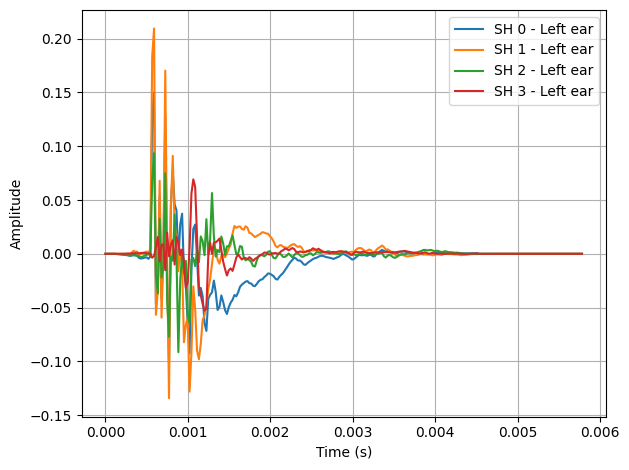

In [2]:
# Create HRIRReader object
sofa_path = Path('../data/Week 2/hrtf/CIPIC_subject_119_fixed.sofa').resolve()
hrir_reader = HRIRReader(sofa_path)

# Create an HRIRSet from the read file
hrir_data = HRIRSet(hrir_reader.fs, hrir_reader.num_meas, hrir_reader.ir_length, hrir_reader.ir_data,
                    hrir_reader.listener_view, hrir_reader.listener_view_type)

### WRITE YOUR CODE HERE ###
# Get the HRIRs in the spherical harmonic domain, plot for sanity check
hrir_spherical = hrir_data.get_spherical_harmonic_representation(ambi_order=1)

num_ambi_channels = hrir_spherical.shape[0]
num__time_samples = hrir_spherical.shape[2]
time = np.arange(num__time_samples) / hrir_data.fs  # time in seconds

plt.figure()
for ch in range(num_ambi_channels):
    plt.plot(time, hrir_spherical[ch, 0, :], label=f'SH {ch} - Left ear')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Part 2

- Complete `convert_srir_to_brir` in `spatial_audio.spatial.py`.
  * Read the SRIRs you have saved in the last assignment using the `sofar` library along with their positions.
  * Use the SH-encoded HRIRs and the SRIRs you have read to obtain BRIRs for head orientations spanning an azimuth of $-180^\circ$ to $+180^\circ$ and elevation of $-90^\circ$ to $+90^\circ$ in $15^\circ$ steps.

The BRIRs, $b_{L,R}(\mathbf{x}, \Omega_0, t)$ at positions $\mathbf{x}$ and orientation $\Omega_0 = [\theta_0, \phi_0]$ are given by,
\begin{equation}
\begin{aligned}
\mathbf{H}_{\text{sh}_{\text{rot}}}(\mathbf{x}, f) &=  \mathbf{D}(-\Omega_0) \mathbf{H}_\textrm{sh}(\mathbf{x}, f), \\
B_{\text{L, R}}(\mathbf{x}, \Omega_0, f) &=\left(\sum_{n=0}^{(N+1)^2-1} \mathbf{G}^{(n)*}_{\text{sh}_{L,R}}(f)  \mathbf{H}^{(n)}_{\text{sh}_{\text{rot}}}(\mathbf{x}, f)\right), \\
b_{\text{L, R}}(\mathbf{x}, \Omega_0, t) &= \text{IFFT}(B_{\text{L, R}}(\mathbf{x}, \Omega_0, f)).
\end{aligned}
\end{equation}
Here, $\mathbf{G}_{\text{sh}_{L,R}}(f) \in \mathbb{R}^{(N+1)^2 \times F}$ are the conjugated HRTFs in the spherical harmonics domain, $\mathbf{H}_\text{sh}(\mathbf{x}, f) \in \mathbb{R}^{(N+1)^2 \times F}$ are the SH-encoded (B-format) frequency-domain SRIRs at position $\mathbf{x}$ and $\mathbf{H}_{\text{sh}_\text{rot}}(\mathbf{x}, f)$ are frequency-domain SRIRs rotated in the direction $-\Omega_0$. $\mathbf{H}_{\text{sh}_\text{rot}}(\mathbf{x}, f)$ is obtained from the SH-encoded frequency-domain SRIRs, $\mathbf{H}_\text{sh}(\mathbf{x}, f)$ using a rotation matrix, $\mathbf{D}(-\Omega_0)$. You can use `spaudiopy`'s `sph.sh_rotation_matrix` for $\mathbf{D}(\Omega_0)$. Notice we replaced the convolution operation with point-wise multiplication in the SH domain.

In [3]:
# read SRIRs from SOFA file
srir_path = Path('../data/Week 2/shoe-box-synth-comp/sofa_files/racquetball_src=B_srirs.sofa').resolve()
sofa_obj = sofar.read_sofa(srir_path, verify=True, verbose=True)

# read sample rate
fs = sofa_obj.Data_SamplingRate
# we are only interested in a single receiver position
num_rec = 1
# read SRIR
srirs = sofa_obj.Data_IR[:num_rec, ...]
# read listener position
listener_position = sofa_obj.ListenerPosition[:num_rec]
# read source position
source_position = sofa_obj.SourcePosition[1]

# Create head orientation array
grid_res = 15
az = np.arange(-180, 180, grid_res)
el = np.arange(-90, 90, grid_res)
az_grid, el_grid = np.meshgrid(az, el)
head_orientation = np.stack((az_grid.ravel(), el_grid.ravel(), np.ones_like(az_grid.ravel()))).T
num_orientation = head_orientation.shape[0]

In [4]:
print(hrir_spherical.shape, head_orientation.shape, srirs.shape)

(4, 2, 256) (288, 3) (1, 4, 287999)


In [5]:
### WRITE YOUR CODE HERE ####

# Get BRIRs from SRIRs and SH-HRIRs by calling convert_srir_to_brir, 
# Save them in a variable called brirs
brirs = convert_srir_to_brir(srirs, hrir_spherical, head_orientation)

2025-07-30 17:04:38.404 | INFO     | spatial_audio.spatial:convert_srir_to_brir:91 - Done calculating FFTs
100%|██████████| 1/1 [00:09<00:00,  9.08s/it]


### Part 3
- Save the obtained BRIRs for a SINGLE source and receiver position in SOFA format using the `HRIRWriter`class.
- The different head orientations will be saved as source positions. For example if your source positions is C and receiver position is A, then save the BRIRs as `racquetball_src=C_rec=A.sofa`.

In [12]:
# number of measurements
M = num_rec * num_orientation

# number of receivers
R = 2

# trim BRIRs to 4s
trim_len_samps = ms_to_samps(4000, fs)
brirs = brirs[..., :trim_len_samps, :]
brirs /= np.max(np.abs(brirs))

# BRIR length in time
N = trim_len_samps

# reshape BRIRs to be of shape (number_of_measurements, number_of_receivers, BRIR_length_in_time)
brirs_flat = brirs.reshape(M, N, R)
brirs_flat = np.transpose(brirs_flat, (0, 2, 1))  # → shape (M, R, N)

# create listener positions, listener views and source positions
# all are of shape  (num_rec * num_ori, 3)
listener_positions_all = np.repeat(listener_position, num_orientation, axis=0)
listener_views_all = np.tile(head_orientation, (num_rec, 1))
source_positions_all = np.repeat(source_position[np.newaxis, :], M, axis=0)

# Path to save
brir_sofa_path = Path('../data/Week 2/shoe-box-synth-comp/sofa_files/racquetball_src=I_rec=A_brirs.sofa').resolve()

### WRITE YOUR CODE HERE ###

# create HRIRSet object for BRIRs
brir_set = HRIRSet(fs, M, N, brirs_flat, listener_views_all, listener_view_type='cartesian')

# create sofa writer object with HRIRSet, set_list_view_as_source_pos = True
sofa_writer = HRIRWriter(brir_set, set_list_view_as_source_pos=True)

# call sofa_writer.write_to_file
sofa_writer.write_to_file(brir_sofa_path)

#### Sanity check to see if SOFA saving was successful

2025-07-31 09:30:47.502 | INFO     | spatial_audio.sofa_parser:__init__:41 - None
2025-07-31 09:30:47.502 | INFO     | spatial_audio.sofa_parser:__init__:42 - Shape of the IRs is (288, 2, 192000)


R = 2 receiver (set by ReceiverPosition of dimension RCI, RCM)
E = 1 emitter (set by EmitterPosition of dimension ECI, ECM)
M = 288 measurements (set by Data_IR of dimension MRN)
N = 192000 samples (set by Data_IR of dimension MRN)
C = 3 coordinate dimensions, fixed
I = 1 single dimension, fixed
S = 0 maximum string length



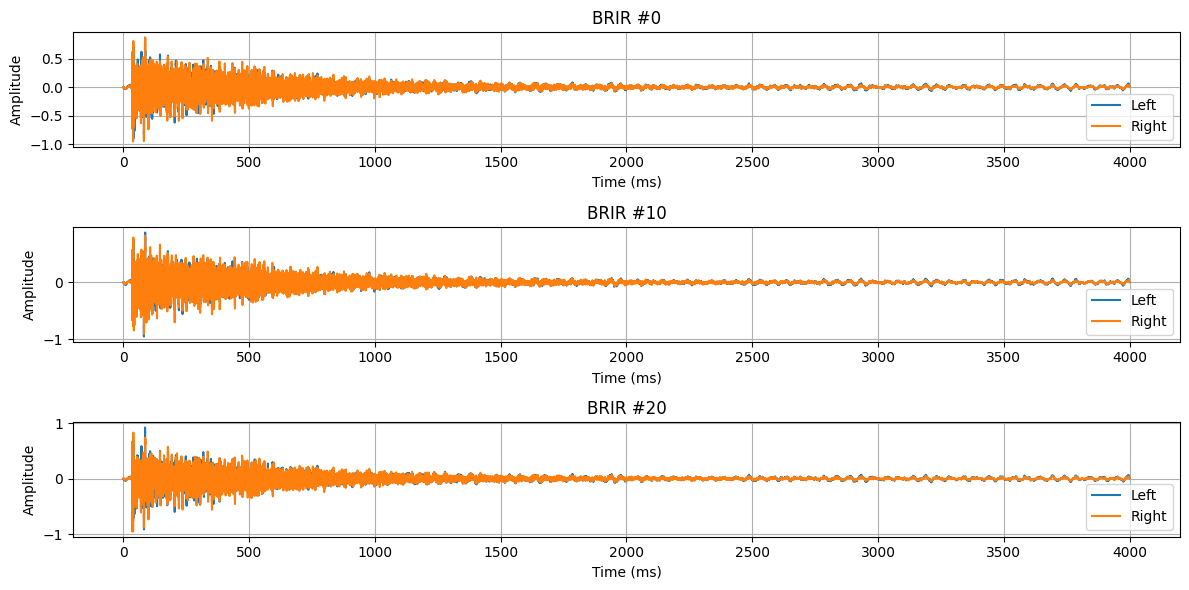

In [ ]:
sofa_reader = HRIRReader(brir_sofa_path)

fs = sofa_reader.fs
brirs = sofa_reader.ir_data  # shape: (M, 2, N)
times = np.arange(brirs.shape[2]) / fs

# plot a few BRIRs
example_indices = [0, 10, 20]

# Plot
plt.figure(figsize=(12, 6))
for i, idx in enumerate(example_indices):
    plt.subplot(len(example_indices), 1, i + 1)
    plt.plot(times * 1000, brirs[idx, 0], label='Left')
    plt.plot(times * 1000, brirs[idx, 1], label='Right')
    plt.title(f'BRIR #{idx}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
